In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [4]:
import scanpy as sc

adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Batch_corrected\Hao_PBMC_Harmony_unscaled.h5ad")
# adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/batch_corrected/Hao_PBMC_Harmony_unscaled.h5ad')
print('Original adata:', adata.shape)
adata.obs['celltype.l2'] = adata.obs['celltype.l2'].str.replace(' ', '_')
label = adata.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print('====================')
# del adata


Original adata: (161764, 33538)
all cell types: ['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


In [5]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14 Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4 T,CD4_TCM,CD4 TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8 T,CD8_Naive,CD8 Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8 T,CD8_Naive,CD8 Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## Read features

In [6]:
import os
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level2_log_inv/feature_selection')
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch\Level2_log_inv\feature_selection")

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue


# read new features from lambda decision v3
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch\Level2_log_inv\feature_selection_v3")
queue = ['dnT', 'Treg', 'CD8_Proliferating', 'ILC', 'CD8_TCM']
for celltype in queue:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        print('Updating features for:', celltype)
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

Updating features for: dnT
Updating features for: Treg
Updating features for: CD8_Proliferating
Updating features for: ILC
Updating features for: CD8_TCM


In [7]:
features_dict.keys()

dict_keys(['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC'])

In [8]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
ASDC,27,16
B_intermediate,16,7
B_memory,35,16
B_naive,8,6
CD14_Mono,17,9
CD16_Mono,15,5
CD4_CTL,90,31
CD4_Naive,151,91
CD4_Proliferating,26,19
CD4_TCM,82,48


## Build classifiers (K-fold CV)

In [9]:
import pickle

def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }
    cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return clf, mean_metrics

In [11]:
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level2_log_inv/LR_classifiers')
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch\Level2_log_inv\LR_classifiers")

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = LR_kfold(adata, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output LR model as pickle
    filename = f'LR_{celltype}_Harmony_l2.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)


K-fold CV for: ASDC
[0.9999319995503975, 0.9482142857142858, 0.9075, 0.9268075639599556, 0.9999670149552358, 0.9665492628149781, 0.9272986892102175]
K-fold CV for: B_intermediate
[0.9902265032254387, 0.7501391568452925, 0.5273430172129693, 0.6163917881706051, 0.9927168277762259, 0.7061306894679996, 0.6228157466627067]
K-fold CV for: B_memory
[0.9963836198182004, 0.9198074629598111, 0.9010654490106547, 0.9098023509221367, 0.9988871201397241, 0.9648783287684021, 0.9082872882481418]
K-fold CV for: B_naive
[0.9952585240758605, 0.9507472280229055, 0.9502446280880728, 0.9502772137944866, 0.9993457144425545, 0.9859744559925072, 0.9479085601849698]
K-fold CV for: CD14_Mono
[0.9895835882335083, 0.9766247453105776, 0.9841180604356993, 0.9803409377412906, 0.9987258480849898, 0.9943096520777616, 0.9732839596279058]
K-fold CV for: CD16_Mono
[0.9936512538887372, 0.9172849724788634, 0.9213607594936709, 0.9191572828487239, 0.9985601544821309, 0.9537889472466136, 0.9159432270944692]
K-fold CV for: CD4_

In [12]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
ASDC,0.999932,0.948214,0.907500,0.926808,0.999967,0.966549,0.927299
B_intermediate,0.990227,0.750139,0.527343,0.616392,0.992717,0.706131,0.622816
B_memory,0.996384,0.919807,0.901065,0.909802,0.998887,0.964878,0.908287
B_naive,0.995259,0.950747,0.950245,0.950277,0.999346,0.985974,0.947909
CD14_Mono,0.989584,0.976625,0.984118,0.980341,0.998726,0.994310,0.973284
CD16_Mono,0.993651,0.917285,0.921361,0.919157,0.998560,0.953789,0.915943
CD4_CTL,0.996241,0.855157,0.785162,0.817115,0.997504,0.900380,0.816770
CD4_Naive,0.971984,0.875374,0.868928,0.871178,0.991701,0.936805,0.856080
CD4_Proliferating,0.999666,0.800373,0.704762,0.735750,0.999818,0.864085,0.743847
CD4_TCM,0.963793,0.824497,0.783596,0.799850,0.986991,0.880312,0.782509


In [15]:
# save metrics
all_metrics.index = types
all_metrics.to_csv('LR_metrics_l2_v3.csv')

## Read saved .pkl

## Plot classifier K-fold CV metrics

In [16]:
# try:
#     del all_metrics
# except:
#     pass

# # Load metrics
# all_metrics = pd.read_csv('LR_metrics_l2.csv', index_col=0)
# all_metrics

In [18]:
# drop irrelevant celltypes
irrelevant = ['Doublet', 'Eryth', 'Platelet']
all_metrics = all_metrics.drop(irrelevant, axis=0)

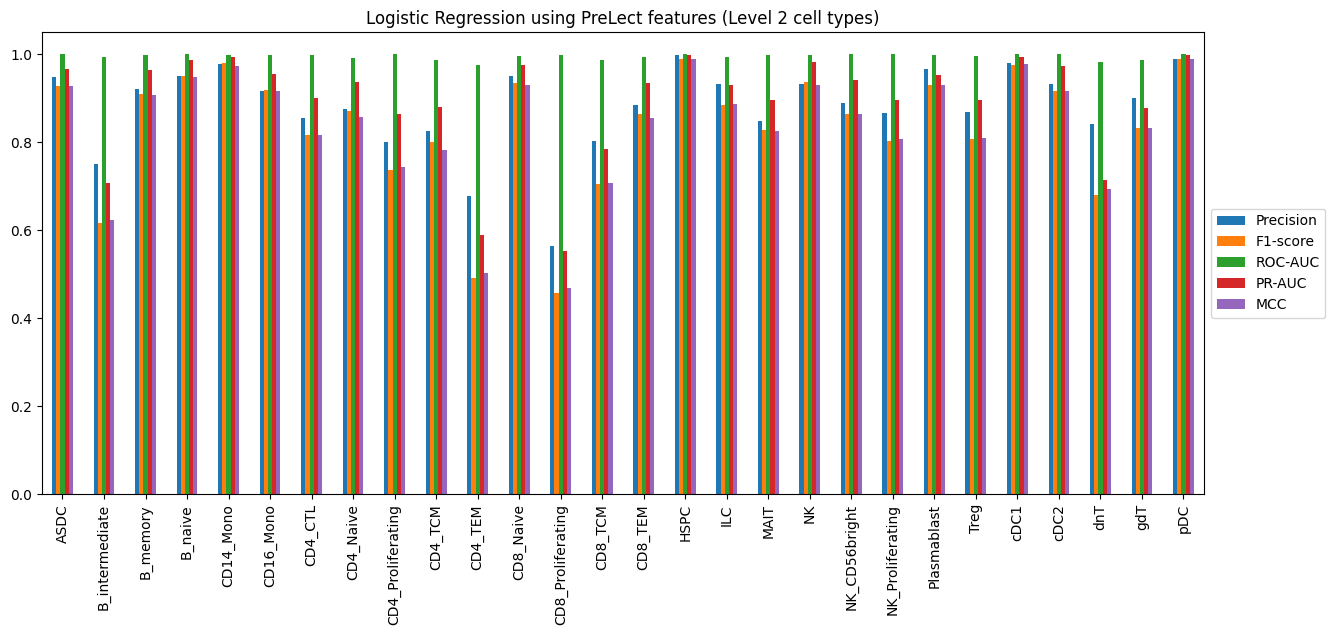

In [19]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']

# Plot metrics for each celltype
ax = all_metrics[cols].plot.bar(rot=90, figsize=(15,6), title='Logistic Regression using PreLect features (Level 2 cell types)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))